# OBJETIVO
* Análise exploratória dos dados com os seguintes fins:
    * Identificação das localidades onde cada modelo tem os maiores preços
    * Verificação da quilometragem ótima de venda

# Carregamento de pacotes

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Configuração do notebook

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Funções

In [3]:
# Função para montagem do histograma
def show_outliers_boxplots(df, info):
    Q1 = df[info].quantile(0.25)
    Q3 = df[info].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    ancor = ' -> 0' if lower_lim < 0 else ''
    print(f'lower limit = {lower_lim}{ancor}')
    print(f'upper limit = {upper_lim}')
    limits = [lower_lim, upper_lim]
    df_clean = df[(df[info] >= lower_lim) & (df[info] <= upper_lim)]

    fig, axis = plt.subplots(nrows=2)
    plt.subplots_adjust(hspace = 1)
    sns.boxplot(df_clean[info], ax=axis[0]).set_title('COM outliers')
    sns.boxplot(df_clean[info], ax=axis[1]).set_title('SEM outliers')
    plt.show()

    return limits, df_clean


def plot(df, info, type = 'lineplot', sort=False, xtick_rotation=30, color='lightblue'):
    fig, ax = plt.subplots()
    if sort:
        df_sorted = df.sort_values(by=info)
    else:
        df_sorted = df
    exec(f"sns.{type}(df_sorted.index, df_sorted[info], color='{color}')")
    plt.xticks(rotation=xtick_rotation, ha='right')
    plt.show()


def relative_value(df, base_index, info):
    base_value = df[info][base_index]
    col_name = f'{info}_DiferençaRelativa{base_index}_(%)'
    df[col_name] = (df[info]/base_value)*100 -100
    return df, col_name


# Carregamento da base de dados

In [4]:
df_full = pd.read_csv('base_tratada.csv')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92291 entries, 0 to 92290
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           92291 non-null  int64  
 1   Marca                92291 non-null  object 
 2   Modelo               92291 non-null  object 
 3   AnoModelo            92291 non-null  int64  
 4   AnoFabricacao        92291 non-null  int64  
 5   Quilometragem        92291 non-null  int64  
 6   PrecoAnuncio         92291 non-null  float64
 7   TipoAnuncio          92291 non-null  object 
 8   Cidade               92291 non-null  object 
 9   Estado               92291 non-null  object 
 10  Pais                 92291 non-null  object 
 11  MarketPlace          86080 non-null  object 
 12  Vendedor             92291 non-null  object 
 13  vendedorMarketplace  92291 non-null  object 
 14  Descricao            92291 non-null  object 
 15  VolumeMotor          92291 non-null 

In [5]:
df_full.drop('Unnamed: 0', axis=1, inplace=True)
df_full['VolumeMotor'] = df_full['VolumeMotor'].apply(str)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92291 entries, 0 to 92290
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Marca                92291 non-null  object 
 1   Modelo               92291 non-null  object 
 2   AnoModelo            92291 non-null  int64  
 3   AnoFabricacao        92291 non-null  int64  
 4   Quilometragem        92291 non-null  int64  
 5   PrecoAnuncio         92291 non-null  float64
 6   TipoAnuncio          92291 non-null  object 
 7   Cidade               92291 non-null  object 
 8   Estado               92291 non-null  object 
 9   Pais                 92291 non-null  object 
 10  MarketPlace          86080 non-null  object 
 11  Vendedor             92291 non-null  object 
 12  vendedorMarketplace  92291 non-null  object 
 13  Descricao            92291 non-null  object 
 14  VolumeMotor          92291 non-null  object 
 15  Trasmissao           92291 non-null 

# Coleta de amostra da base de dados

In [6]:
df = df_full
# df = df_full.head(10)
# df = df_full.sample(50)

df.head()

,Marca,Modelo,AnoModelo,AnoFabricacao,Quilometragem,PrecoAnuncio,TipoAnuncio,Cidade,Estado,Pais,MarketPlace,Vendedor,vendedorMarketplace,Descricao,VolumeMotor,Trasmissao,Combustivel
0,KIA,SPORTAGE,2020,2019,1628,171480.0,PJ,SAO PAULO,SP,BR,NaN,LOCALIZA,Localiza,EX 2.0 FLEX 4P C/AR - AUTOMATICO,2.0,AUTOMATICO BOM,OUTRO
1,FORD,ECOSPORT,2020,2019,5940,81450.0,PJ,SAO PAULO,SP,BR,NaN,LOCALIZA,Localiza,SE 1.5 12V FLEX 4P C/AR - AUTOMATICO,1.5,AUTOMATICO BOM,OUTRO
2,FORD,ECOSPORT,2020,2019,6830,81070.0,PJ,OSASCO,SP,BR,NaN,LOCALIZA,Localiza,SE 1.5 12V FLEX 4P C/AR - AUTOMATICO,1.5,AUTOMATICO BOM,OUTRO
3,BMW,X4,2017,2016,7454,295910.0,PJ,SAO PAULO,SP,BR,NaN,LOCALIZA,Localiza,XDRIVE 35I M SPORT 3.0 4P C/AR - AUTOMATICO BL...,3.0,AUTOMATICO BOM,OUTRO
4,JEEP,RENEGADE,2019,2019,7496,94060.0,PJ,NITEROI,RJ,BR,NaN,LOCALIZA,Localiza,LONGITUDE 1.8 16V FLEX 4P C/AR - AUTOMATICO,1.8,AUTOMATICO BOM,OUTRO


# Análise dos dados com base no modelo

In [7]:
models = np.sort(df['Modelo'].unique())

print('MODELOS')
print(models)

MODELOS
['2008' '207' '208' '220I' '3008' '308' '308CC' '320I' '408' '5008' '508'
 '535I' '540I' 'A3 SEDAN' 'A4 HATCH' 'A4 SEDAN' 'AMAROK' 'ARGO' 'ARRIZO 6'
 'BOXER' 'C 180' 'C 250' 'C 300' 'C4' 'C4 CACTUS' 'C4 GRAND PICASSO'
 'C4 LOUNGE' 'CAMRY' 'CAPTUR' 'CARNIVAL' 'CITY' 'CIVIC' 'CLA 180'
 'CLASSE C' 'COBALT' 'COMPASS' 'COROLLA' 'CRETA' 'CRONOS' 'CRUZE HATCH'
 'CRUZE SEDAN' 'DISCOVERY SPORT' 'DOBLO' 'DUCATO' 'DUSTER' 'DUSTER OROCH'
 'E 250' 'E 63 AMG' 'E-PACE' 'ECOSPORT' 'EDGE' 'EQUINOX' 'ETIOS HATCH'
 'ETIOS SEDAN' 'EXPERT' 'FIESTA' 'FIORINO' 'FIT' 'FLUENCE' 'FOCUS HATCH'
 'FOCUS SEDAN' 'FORESTER' 'FOX' 'FRONTIER' 'FUSION' 'GLA 200' 'GLA 250'
 'GLC 250' 'GOL' 'GRAND SIENA' 'HB20' 'HB20S' 'HILUX' 'HOGGAR' 'HR-V'
 'IDEA' 'IX35' 'JETTA' 'JUMPY' 'KA HATCH' 'KA SEDAN' 'KANGOO' 'KICKS'
 'KWID' 'L200 TRITON' 'LANCER' 'LEAF' 'LOGAN' 'MARCH' 'MASTER' 'MOBI'
 'MONTANA' 'NIVUS' 'ONIX' 'OUTLANDER' 'PAJERO FULL' 'PALIO' 'PARTNER'
 'PASSAT' 'POLO' 'PRISMA' 'PRIUS' 'Q3' 'Q5' 'RANGE ROVER EVOQUE'
 

In [8]:
# Escolha do modelo a ser analisado
model_choice = ['S10']

df_filtered = df[df['Modelo'].isin(model_choice)]
df_filtered

,Marca,Modelo,AnoModelo,AnoFabricacao,Quilometragem,PrecoAnuncio,TipoAnuncio,Cidade,Estado,Pais,MarketPlace,Vendedor,vendedorMarketplace,Descricao,VolumeMotor,Trasmissao,Combustivel
5225,CHEVROLET,S10,2020,2020,57574,136990.0,PJ,BRASILIA,DF,BR,NaN,UNIDAS,Unidas,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
10430,CHEVROLET,S10,2020,2019,0,155800.0,PJ,ITAJAI,SC,BR,WEBMOTORS,WEBMOTORS,REGATA VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
11537,CHEVROLET,S10,2017,2017,100,92990.0,PJ,SANTAREM,PA,BR,WEBMOTORS,WEBMOTORS,SANDRO VEICULOS,2.5 ADVANTAGE 4X2 CD 16V FLEX 4P MANUAL,2.5,MANUAL,OUTRO
11628,CHEVROLET,S10,2017,2016,100,129900.0,PJ,RIO DAS OSTRAS,RJ,BR,WEBMOTORS,WEBMOTORS,AVANT VEICULOS,2.5 ADVANTAGE 4X2 CD 16V FLEX 4P MANUAL,2.5,MANUAL,OUTRO
11658,CHEVROLET,S10,2020,2019,100,165000.0,PJ,BELEM,PA,BR,WEBMOTORS,WEBMOTORS,SAM JOHNNY VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91659,CHEVROLET,S10,2018,2017,180000,149900.0,PJ,MARINGA,PR,BR,WEBMOTORS,WEBMOTORS,GRAN VIA VEICULOS,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL
91681,CHEVROLET,S10,2017,2016,186000,139900.0,PF,CAIEIRAS,SP,BR,WEBMOTORS,WEBMOTORS,EDSON,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL
91716,CHEVROLET,S10,2018,2018,192319,135900.0,PJ,PRIMAVERA DO LESTE,MT,BR,WEBMOTORS,WEBMOTORS,ZAHER,2.8 LS 4X4 CS 16V TURBO DIESEL 2P MANUAL,2.8,MANUAL,DIESEL
91787,CHEVROLET,S10,2018,2017,207293,149900.0,PJ,JABOTICABAL,SP,BR,WEBMOTORS,WEBMOTORS,PONTO FORTE,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL


In [9]:
# Oções de combustível
fuels = np.sort(df_filtered['Combustivel'].unique())

print('COMBUSTÍVEIS')
print(fuels)

COMBUSTÍVEIS
['DIESEL' 'OUTRO']


In [10]:
fuel_choice = ['DIESEL']

df_fuel_filtered = df_filtered[df['Combustivel'].isin(fuel_choice)]
df_fuel_filtered

,Marca,Modelo,AnoModelo,AnoFabricacao,Quilometragem,PrecoAnuncio,TipoAnuncio,Cidade,Estado,Pais,MarketPlace,Vendedor,vendedorMarketplace,Descricao,VolumeMotor,Trasmissao,Combustivel
5225,CHEVROLET,S10,2020,2020,57574,136990.0,PJ,BRASILIA,DF,BR,NaN,UNIDAS,Unidas,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
10430,CHEVROLET,S10,2020,2019,0,155800.0,PJ,ITAJAI,SC,BR,WEBMOTORS,WEBMOTORS,REGATA VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
11658,CHEVROLET,S10,2020,2019,100,165000.0,PJ,BELEM,PA,BR,WEBMOTORS,WEBMOTORS,SAM JOHNNY VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
12685,CHEVROLET,S10,2017,2016,1111,149990.0,PJ,IVOTI,RS,BR,WEBMOTORS,WEBMOTORS,AUTO INOVA VEICULOS,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL
14323,CHEVROLET,S10,2020,2019,5300,159900.0,PJ,BLUMENAU,SC,BR,WEBMOTORS,WEBMOTORS,ZIMMERMANN VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91630,CHEVROLET,S10,2019,2018,177000,169900.0,PJ,MEDIANEIRA,PR,BR,WEBMOTORS,WEBMOTORS,CARRER MULTIMARCAS,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL
91659,CHEVROLET,S10,2018,2017,180000,149900.0,PJ,MARINGA,PR,BR,WEBMOTORS,WEBMOTORS,GRAN VIA VEICULOS,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL
91681,CHEVROLET,S10,2017,2016,186000,139900.0,PF,CAIEIRAS,SP,BR,WEBMOTORS,WEBMOTORS,EDSON,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL
91716,CHEVROLET,S10,2018,2018,192319,135900.0,PJ,PRIMAVERA DO LESTE,MT,BR,WEBMOTORS,WEBMOTORS,ZAHER,2.8 LS 4X4 CS 16V TURBO DIESEL 2P MANUAL,2.8,MANUAL,DIESEL


# Análise de outliers

lower limit = -15200.0 -> 0
upper limit = 148320.0


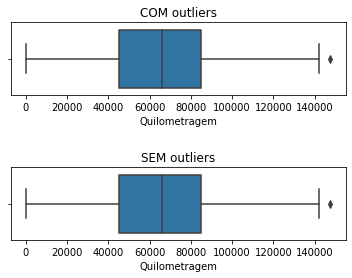

In [11]:
# Outliers de quilometragem
info = 'Quilometragem'
limits_km = show_outliers_boxplots(df_fuel_filtered, info)
df_fuel_filtered = limits_km[1] # retira os outliers de km da base

lower limit = 85975.0
upper limit = 230015.0


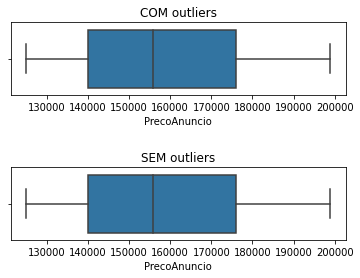

In [12]:
# Outliers de preço anunciado

info = 'PrecoAnuncio'
limits_price = show_outliers_boxplots(df_fuel_filtered, info)
df_fuel_filtered = limits_price[1] # retira os outliers de preço da base


# Análise influência das versões e do ano do modelo sobre o preço

In [13]:
df_fuel_filtered.head()

,Marca,Modelo,AnoModelo,AnoFabricacao,Quilometragem,PrecoAnuncio,TipoAnuncio,Cidade,Estado,Pais,MarketPlace,Vendedor,vendedorMarketplace,Descricao,VolumeMotor,Trasmissao,Combustivel
5225,CHEVROLET,S10,2020,2020,57574,136990.0,PJ,BRASILIA,DF,BR,NaN,UNIDAS,Unidas,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
10430,CHEVROLET,S10,2020,2019,0,155800.0,PJ,ITAJAI,SC,BR,WEBMOTORS,WEBMOTORS,REGATA VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
11658,CHEVROLET,S10,2020,2019,100,165000.0,PJ,BELEM,PA,BR,WEBMOTORS,WEBMOTORS,SAM JOHNNY VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL
12685,CHEVROLET,S10,2017,2016,1111,149990.0,PJ,IVOTI,RS,BR,WEBMOTORS,WEBMOTORS,AUTO INOVA VEICULOS,2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,2.8,AUTOMATICO BOM,DIESEL
14323,CHEVROLET,S10,2020,2019,5300,159900.0,PJ,BLUMENAU,SC,BR,WEBMOTORS,WEBMOTORS,ZIMMERMANN VEICULOS,2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,2.8,MANUAL,DIESEL


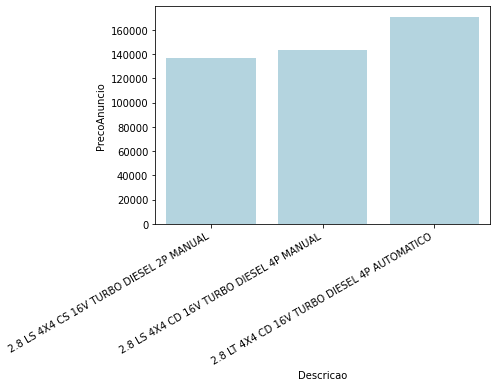

In [14]:
group = 'Descricao'
info = 'PrecoAnuncio'
df_group = df_fuel_filtered.groupby([group]).mean()
plot(df_group, info, sort=True, type='barplot')

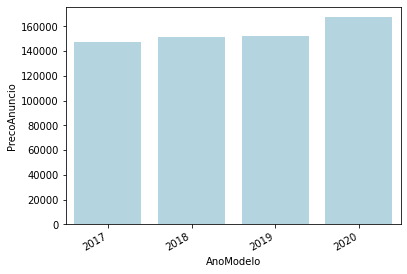

In [15]:
group = 'AnoModelo'
info = 'PrecoAnuncio'
df_group = df_fuel_filtered.groupby([group]).mean()
plot(df_group, info, type='barplot')

# Análise da variação de preço por estado

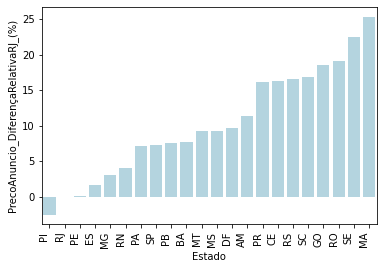

In [16]:
# Variação de preço por estado
base_index = 'RJ' # Estado referência para cálculo do preço relativo

group = 'Estado'
info = 'PrecoAnuncio'
df_group = df_fuel_filtered.groupby([group]).mean()

df_relative = df_group
(df_relative_price, relative_price_col) = relative_value(df_relative, base_index, info)

plot(df_relative_price, relative_price_col, type='barplot', sort=True, xtick_rotation=90)

In [17]:
df_relative_price

,AnoModelo,AnoFabricacao,Quilometragem,PrecoAnuncio,PrecoAnuncio_DiferençaRelativaRJ_(%)
Estado,,,,,
AM,2020.000000,2019.000000,32238.500000,159900.000000,11.329932
BA,2019.666667,2019.000000,64780.333333,154626.666667,7.658388
CE,2019.777778,2019.000000,54391.666667,166928.888889,16.223776
DF,2019.100000,2018.400000,69158.800000,157526.000000,9.677041
ES,2020.000000,2019.000000,38686.000000,145990.000000,1.645133
GO,2019.066667,2018.333333,78787.800000,170292.000000,18.565333
MA,2019.000000,2019.000000,40000.000000,180000.000000,25.324501
MG,2019.120000,2018.120000,59027.720000,147990.360000,3.037878
MS,2019.200000,2018.200000,83800.000000,156940.000000,9.269040


# Análise da variação de preço por tipo de transmissão

In [18]:
# Verificação dos tipos de transmissão disponíveis e cálculo das médias
group = 'Trasmissao'
info = 'PrecoAnuncio'
df_group = df_fuel_filtered.groupby([group]).mean()
print(df_group.index.values)

['AUTOMATICO BOM' 'MANUAL']


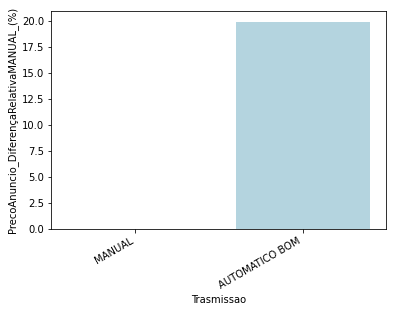

In [19]:
# Variação de preço por tipo de transmissão
base_index = 'MANUAL' # Escolha do tipo de transmissão de referência

df_relative = df_group
(df_relative_price, relative_price_col) = relative_value(df_relative, base_index, info)

plot(df_relative_price, relative_price_col, type='barplot', sort=True)

# Análise da relação do preço com a quilometragem
## Como esta análise trata de diferenças de peço mais sutis, é relevante analisar cada versão do modelo escolhido separadamente

In [20]:
km_min = df_fuel_filtered['Quilometragem'].min()
km_max = df_fuel_filtered['Quilometragem'].max()
print(km_min)
print(km_max)

0
147600


In [21]:
km_bins = [0]
interval = 10000

km_initial = km_bins[0]
while km_initial <= km_max:
    km_bins.append(max(km_bins) + interval)
    km_initial = max(km_bins)

km_bins_labels = []
for i in range(0, len(km_bins)-1):
    km_bins_labels.append(f'{int(km_bins[i]/1000)} - {int(km_bins[i+1]/1000)}')
km_bins_labels

['0 - 10',
 '10 - 20',
 '20 - 30',
 '30 - 40',
 '40 - 50',
 '50 - 60',
 '60 - 70',
 '70 - 80',
 '80 - 90',
 '90 - 100',
 '100 - 110',
 '110 - 120',
 '120 - 130',
 '130 - 140',
 '140 - 150']

In [22]:
model_versions = df_fuel_filtered['Descricao'].unique()
model_versions

array(['2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL',
       '2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO',
       '2.8 LS 4X4 CS 16V TURBO DIESEL 2P MANUAL'], dtype=object)

In [26]:
df_price_by_km = pd.DataFrame()
df_price_by_km.index = model_versions
df_price_by_km

""
2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL
2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO
2.8 LS 4X4 CS 16V TURBO DIESEL 2P MANUAL


In [27]:
for i in range(0, len(km_bins_labels)):
    means = []
    for version in model_versions:
        mean = df_fuel_filtered[(df_fuel_filtered['Descricao'] == version) &
                           (df_fuel_filtered['Quilometragem'] >= km_bins[i]) &
                           (df_fuel_filtered['Quilometragem'] < km_bins[i + 1])].mean()['PrecoAnuncio']
        means.append(mean)    
    df_price_by_km[km_bins_labels[i]] = means

df_price_by_km

,0 - 10,10 - 20,20 - 30,30 - 40,40 - 50,50 - 60,60 - 70,70 - 80,80 - 90,90 - 100,100 - 110,110 - 120,120 - 130,130 - 140,140 - 150
2.8 LS 4X4 CD 16V TURBO DIESEL 4P MANUAL,160233.333333,154990.0,152900.000000,148518.900000,143636.666667,138988.333333,146257.826087,140051.875000,139808.750000,140446.500000,132900.000000,141470.0,134990.0,NaN,NaN
2.8 LT 4X4 CD 16V TURBO DIESEL 4P AUTOMATICO,172430.000000,189400.0,183134.071429,177486.666667,177809.500000,179612.230769,172716.000000,172105.833333,163052.380952,157982.857143,163276.666667,160600.0,169525.0,151596.666667,149750.0
2.8 LS 4X4 CS 16V TURBO DIESEL 2P MANUAL,NaN,NaN,NaN,139950.000000,139999.980000,129900.000000,139930.000000,136566.666667,132349.997500,139990.000000,NaN,137900.0,NaN,NaN,NaN


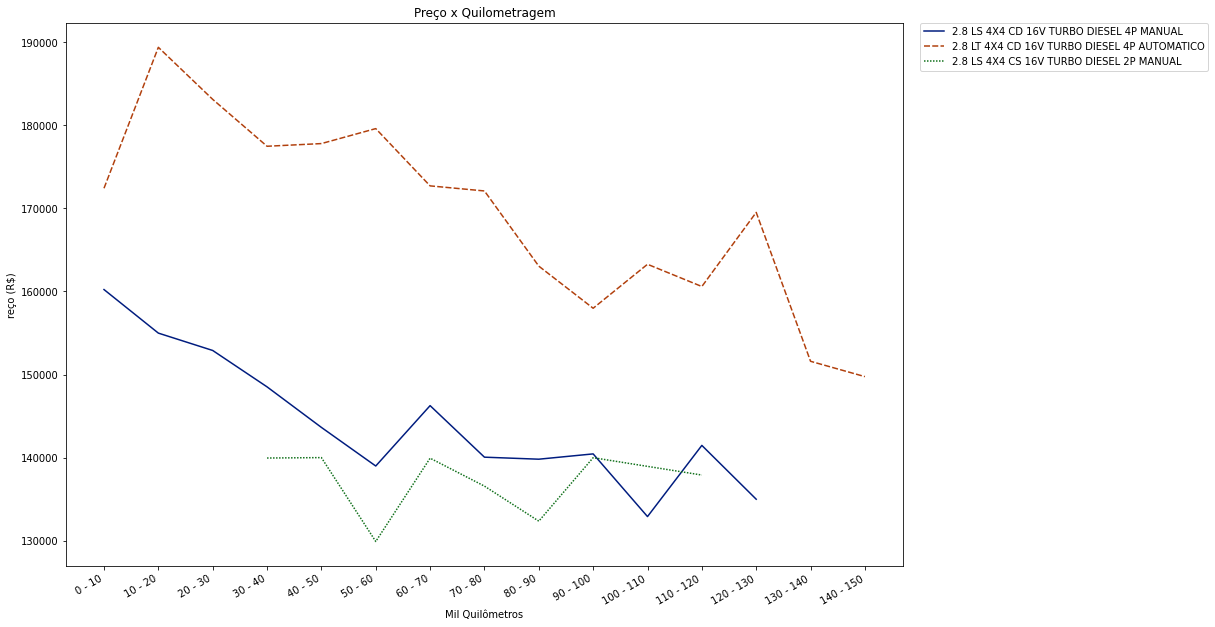

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data = df_price_by_km.transpose(), palette='dark')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Preço x Quilometragem')
plt.xlabel('Mil Quilômetros')
plt.ylabel('reço (R$)')
plt.xticks(rotation=30, ha='right')
plt.show()